# Azure AutoML for Images
## AutoML for Images to train and a deploy an instance segmentation model (Part 2)

Important: This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews.

Serge Retkowsky | serge.retkowsky@microsoft.com | V1 28-June-2022

In this notebook you will:

- Call the deployed model to detect scratches from an image
- Compute the polygon area of each scratch

AutoML for Images links:
What is AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml#computer-vision-preview
<br><br>
Algorithms<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms
<br><br>
Tutorials<br>
https://docs.microsoft.com/en-us/azure/machine-learning/v1/tutorial-auto-train-image-models-v1
<br><br>
ONNX<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-inference-onnx-automl-image-models?tabs=multi-class
<br><br>
How to use AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-automl-small-object-detect
https://docs.microsoft.com/en-us/azure/machine-learning/v1/how-to-auto-train-image-models-v1

In [1]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image
from os.path import exists
import requests
import json
import datetime
import time
import matplotlib.pyplot as plt
import uuid
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import os
import cv2
import humanize
import glob
import imageio
import pytz
import urllib
from zipfile import ZipFile
import urllib.request
from sklearn.cluster import KMeans

In [2]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
print("Today:", datetime.datetime.now())

Today: 2022-06-28 08:36:36.993080


In [4]:
import azureml.core
print("Azure ML version:", azureml.core.VERSION)

Azure ML version: 1.41.0


## 1. Azure ML workspace

In [5]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, 
      "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


## 2. Defining a class object to display the JSON model results

In [6]:
class RenderJSON(object):
    def __init__(self, json_data):

        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)

        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):

        display_html(
            '<div id="{}" style="height: 600px; width:100%;"></div>'.format(
                self.uuid),
            raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str),
            raw=True)

## 3. Let's use the deployed model we made

In [7]:
service = Webservice(workspace=ws, name='metal-scratch-detection')

In [8]:
#print(service.scoring_uri)
#print(service.swagger_uri)

In [9]:
primary, secondary = service.get_keys()

In [10]:
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

## 4. Functions

In [11]:
def createdir(MYDIR):
    
    # Create directory
    if not os.path.exists(MYDIR):  # Only if dir not exist
        print("Dir:", MYDIR, "is not available.")
        print("So let's create dir:", MYDIR)
        os.mkdir(MYDIR)
        print("Done.")

    else:
        print("Directory:", MYDIR, "is available. We can use it.")

In [12]:
def listfiles(MYDIR):
    
    # List files from a directory
    nb = 1
    print("Files in directory:", MYDIR, "\n")
    
    for file in os.scandir(MYDIR):
        print(nb, '\t', datetime.datetime.fromtimestamp(file.stat().st_atime),
              '\t', file.name, humanize.naturalsize(file.stat().st_size))
        nb += 1

In [13]:
def imageview(MYIMAGE, w=15, h=10):
    
    # View image
    if exists(MYIMAGE):
        print("Image file:", MYIMAGE)
        %matplotlib inline
        plt.figure(figsize=(w, h)) 
        plt.axis('off')
        img = cv2.cvtColor(cv2.imread(MYIMAGE), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        
    if not exists(MYIMAGE):
        print("File:", MYIMAGE, "not available.")

In [14]:
def polygonsurface(x, y):
    
    # Calculates the area or surface of an arbitrary polygon given its verticies
    surface = 0.0
    polygon_surface = 0.0

    for i in range(-1, len(x) - 1):
        surface += x[i] * (y[i + 1] - y[i - 1])

    polygon_surface = abs(surface) / 2.0

    return polygon_surface

In [15]:
def scratchsurface():
    # Calculation of the scratch surface from a polygon given its verticies
    i = j = 0
    polygon_x = []

    while i < len(polygon[0]):
        x = polygon[0][i]
        polygon_x.insert(j, x)
        i += 2
        j += 1

    i = 1
    j = 0
    polygon_y = []

    while i < len(polygon[0]):
        x = polygon[0][i]
        polygon_y.insert(j, x)
        i += 2
        j += 1

    scratch_surface = polygonsurface(polygon_x,
                                     polygon_y)  # Calling the function
    print("Scratch surface =", round(scratch_surface, 5))

    return scratch_surface

In [16]:
def callingmodel(MYIMAGE, MIN_SCORE=0.8):
    
    # Calling the AutoML model

    # Init
    nb_scratch = totalsurface = 0
    
    t1 = time.time()
    print("Model predictions for image file:", MYIMAGE, " using minimum confidence score=", MIN_SCORE, "\n")

    # Reading image
    img = Image.fromarray(mpimg.imread(MYIMAGE).astype("uint8"), "RGB")
    x, y = img.size
    imgsize = x * y # Get image size

    # Calling the model
    data = open(MYIMAGE, "rb").read()
    headers = {"Content-Type": "application/octet-stream"}
    headers["Authorization"] = f"Bearer {key}"
    resp = requests.post(scoring_uri, data, headers=headers) # Calling the model
    detections = json.loads(resp.text) # Loading the JSON results

    # Processing the results
    for detect in detections["boxes"]:
        if detect["score"] > MIN_SCORE:  # Min Value
            label = detect["label"]
            box = detect["box"]
            polygon = detect["polygon"]
            conf_score = detect["score"]

            print("\033[1;31;91m", nb_scratch + 1, label, 'with confidence =',
                  round(conf_score, 5))
            print("\n\033[1;31;34mPolygon:", polygon, '\n')

            i = j = 0
            polygon_x = []

            while i < len(polygon[0]):
                x = polygon[0][i]
                polygon_x.insert(j, x)
                i += 2
                j += 1

            i = 1
            j = 0
            polygon_y = []

            while i < len(polygon[0]):
                x = polygon[0][i]
                polygon_y.insert(j, x)
                i += 2
                j += 1

            # Calling the surface function
            surface = polygonsurface(polygon_x, polygon_y)
            surfacepixels = surface * imgsize
            pctsurfacepixels = surfacepixels / imgsize * 100

            # Printing results
            print("\033[1;31;32mScratch surface =", round(surfacepixels, 5))
            print("\033[1;31;32mScratch % surface =",
                  round(pctsurfacepixels, 2), "%\n")

            totalsurface += surface
            nb_scratch += 1

    if nb_scratch == 0:  # if no scratch
        print("\033[1;31;34m[OK]: No detected scratches")
        totalsurface = totalsurfacepixels = pcttotalsurface = 0

    elif nb_scratch != 0:  # if detected scratches
        totalsurfacepixels = totalsurface * imgsize
        pcttotalsurface = totalsurfacepixels / imgsize * 100

        print("\033[1;31;91m[ALERT]:", nb_scratch,
              "scratch(es) has been detected!")
        print("\nTotal surface =", round(totalsurfacepixels, 5))
        print("Total % surface =", round(pcttotalsurface, 2), "%")

    return resp, detections, nb_scratch, imgsize, totalsurface, totalsurfacepixels, pcttotalsurface

In [17]:
def viewresults(MYIMAGE, MIN_SCORE=0.8):
    
    # Displaying image with results

    %matplotlib inline

    # Values
    font_size1 = 18
    font_size2 = 18
    font_size3 = 15
    txtoffset = 10
    nb_detected_scratch = 0
    nbround = 2
    img_np = img = None

    # Loading image
    #plt.figure(figsize=(15, 12))
    img_np = mpimg.imread(MYIMAGE)
    img = Image.fromarray(img_np.astype("uint8"), "RGB")
    x, y = img.size
    fig, ax = plt.subplots(1, figsize=(15, 12))
    ax.imshow(img_np)
    
    print("Instance Segmentation custom vision model predictions:\n")

    # Loading the predictions
    detections = json.loads(resp.text)

    # Parsing the predictions JSON
    for detect in detections["boxes"]:
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]

        if conf_score > MIN_SCORE:  # Only if > to the min score value
            ymin, xmin, ymax, xmax = (
                box["topY"], box["topX"], box["bottomY"], box["bottomX"])
            topleft_x, topleft_y = x * xmin, y * ymin
            width, height = x * (xmax - xmin), y * (ymax - ymin)

            # Printing results
            print("\033[1;31;34m", nb_detected_scratch + 1,
                  '\tscratch detected:', detect["label"],
                  "with confidence =", round(
                      conf_score, 5), "\tin region:", round(topleft_x, 5),
                  round(topleft_y, 5), round(width, 5), round(height, 5))

            nb_detected_scratch += 1

            # Drawing rectangle of the ROI
            rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                     linewidth=5,
                                     edgecolor='lime', facecolor="none")
            ax.add_patch(rect)

            # Draw text
            label_txt = ' ' + label + ' =' + str(round(conf_score, nbround))
            
            rect_txt = patches.Rectangle((topleft_x - 3, topleft_y - txtoffset * 2.5), 
                                         145, 25,
                                         linewidth=5, edgecolor='none', facecolor="lime")
            ax.add_patch(rect_txt)
            
            plt.text(topleft_x - 5, topleft_y - 5, 
                     label_txt, color='black', fontsize=font_size1)

            # Plotting the polygons
            polygon_np = np.array(polygon[0])
            polygon_np = polygon_np.reshape(-1, 2)
            polygon_np[:, 0] *= x
            polygon_np[:, 1] *= y
            poly = patches.Polygon(
                polygon_np, True, facecolor='red', alpha=0.3)
            ax.add_patch(poly)

            poly_line = Line2D(polygon_np[:, 0], polygon_np[:, 1],
                               linewidth=3, marker="o",
                               markersize=10,
                               color='blue',
                               markerfacecolor='red')
            ax.add_line(poly_line)

            # Saving each ROI into an image file
            regiontopleftx = int(topleft_x)
            regiontoplefty = int(topleft_y)
            regionw = int(width)
            regionh = int(height)

            # Cropping the image to the ROI
            imgtocrop = cv2.imread(MYIMAGE)  # Cropping the image to the ROI
            crop_image = imgtocrop[regiontoplefty:regiontoplefty +
                               regionh, regiontopleftx:regiontopleftx+regionw]
            image_rgb = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
            
            pathname, extension = os.path.splitext(MYIMAGE)
            outputfile1 = ROI_RESULTS_DIR + '/' + os.path.basename(MYIMAGE) +\
            '_' + str(nb_detected_scratch) + '_ROI' + extension
            cv2.imwrite(outputfile1, image_rgb)

    label_title = "Scratch detection model"
    plt.text(20, 20, label_title, color="lime", fontsize=font_size2)
        
    if nb_detected_scratch == 0:
        label_no = "Image file: " + MYIMAGE + " has no scratch"
        plt.text(20, 40, label_no, color="lime", fontsize=font_size2)

    if nb_detected_scratch > 0:
        totalsurface2 = totalsurface * x * y
        pcttotalsurface2 = round(totalsurface2 / (x * y) * 100, 2)
        label_scratch = MYIMAGE + " has " + str(nb_detected_scratch) + " scratch(es)"
        plt.text(20, 40, label_scratch, color="yellow", fontsize=font_size2)
        
        label_surface = "surface =" + str(round(totalsurface2, 2)) + " (" +\
        str(pcttotalsurface2) + "%)"
        plt.text(420, 40, label_surface, color="yellow", fontsize=font_size2)
    
    # Adding extra information to the image
    from datetime import datetime
    labelmsg3 = str(datetime.now(pytz.timezone('Europe/Paris')).strftime("%d/%m/%Y %H:%M:%S")) +\
        " [Powered by Azure ML AutoML for Images]"
    plt.text(20, y - 20, labelmsg3, color="cyan", fontsize=font_size3)

    # View the image
    plt.axis('off')
    plt.show()
    
    # Saving the full results into an image
    image_result_file = RESULTS_DIR + '/' + \
        os.path.basename(MYIMAGE) + '_has_' + \
        str(nb_detected_scratch) + '_scratch.png'
    fig.savefig(image_result_file, dpi=300)  # Saving image
    
    # Printing results
    if nb_detected_scratch == 0:
        print("\033[1;31;34m[OK]: No detected scratch")

    elif nb_detected_scratch != 0:
        print("\n\033[1;31;91m[ALERT]:", nb_detected_scratch,
              "scratch(es) has been detected!")
    
    return image_result_file

In [18]:
def color_distribution(imgfile):
    
    # Color distribution of an image file
    print("Colors distribution for", imgfile)
    
    img = cv2.imread(imgfile)
    plt.figure(figsize=(15, 8))
    blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
    hist_b = cv2.calcHist([blue], [0], None, [256], [0,256])
    hist_g = cv2.calcHist([green], [0], None, [256], [0,256])
    hist_r = cv2.calcHist([red], [0], None, [256], [0,256])
    
    plt.title("RGB color distribution")
    plt.plot(hist_r, color="red", label="red")
    plt.plot(hist_g, color="green", label="green")
    plt.plot(hist_b, color="blue", label="blue")
    plt.legend()
    plt.show() 
    
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    plt.figure(figsize=(15, 8))
    
    plt.title("HSV color distribution")
    h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    hist_h = cv2.calcHist([h], [0], None, [256], [0,256])
    hist_s = cv2.calcHist([s], [0], None, [256], [0,256])
    hist_v = cv2.calcHist([v], [0], None, [256], [0,256])
    plt.plot(hist_h, color='r', label="h")
    plt.plot(hist_s, color='g', label="s")
    plt.plot(hist_v, color='b', label="v")
    
    plt.legend()
    plt.show()

In [32]:
def predominant_colors(imagefile, nbcluster=5):
    # Predominant colors from an image file
    print("Get predominant colors from an image...")
    img1 = cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2RGB)
    img2 = img1.reshape((img1.shape[1] * img1.shape[0], 3))

    kmeans = KMeans(n_clusters = nbcluster)
    s = kmeans.fit(img2)
    labels = kmeans.labels_
    labels = list(labels)
    centroid = kmeans.cluster_centers_
    percent = []
    
    for i in range(len(centroid)):
        j = labels.count(i)
        j = j / (len(labels))
        percent.append(j)
    
    plt.pie(percent, 
            colors = np.array(centroid/255), 
            labels = np.arange(len(centroid)),
            normalize=False,
           )
    
    pietitle = str(nbcluster) + ' predominant colors of image' + imagefile
    plt.title(pietitle)
    plt.show()
    
    print("% distribution of clusters:\n", percent)

## 5. Testing

In [20]:
IMAGES_DIR = "test_images"
createdir(IMAGES_DIR)

Dir: test_images is not available.
So let's create dir: test_images
Done.


### Downloading the test images files

In [21]:
os.chdir(IMAGES_DIR)

download_url="https://github.com/retkowsky/CustomVision_Datasets/raw/master/scratches_test_images.zip?raw=true"
zip_file="scratches_test_images.zip"
print("1. Download the zip file...")
urllib.request.urlretrieve(download_url,filename=zip_file)

with ZipFile(zip_file, 'r') as zip:
    print('2. Unzip the zip file...')
    zip.extractall()
    
print("3. Deleting the zip file...")
os.remove(zip_file)

print("\nDone!")
os.chdir('..')

1. Download the zip file...
2. Unzip the zip file...
3. Deleting the zip file...

Done!


In [22]:
listfiles(IMAGES_DIR)

Files in directory: test_images 

1 	 2022-06-28 08:39:36.450492 	 test1.png 512.8 kB
2 	 2022-06-28 08:39:36.715344 	 test2.png 715.6 kB
3 	 2022-06-28 08:39:36.977197 	 test3.png 732.5 kB
4 	 2022-06-28 08:39:37.283025 	 test4.png 698.8 kB


In [23]:
ROI_RESULTS_DIR = "roi_images"
createdir(ROI_RESULTS_DIR)

Dir: roi_images is not available.
So let's create dir: roi_images
Done.


In [24]:
RESULTS_DIR = "images_results"
createdir(RESULTS_DIR)

Dir: images_results is not available.
So let's create dir: images_results
Done.


### Test 1

Image file: test_images/test1.png


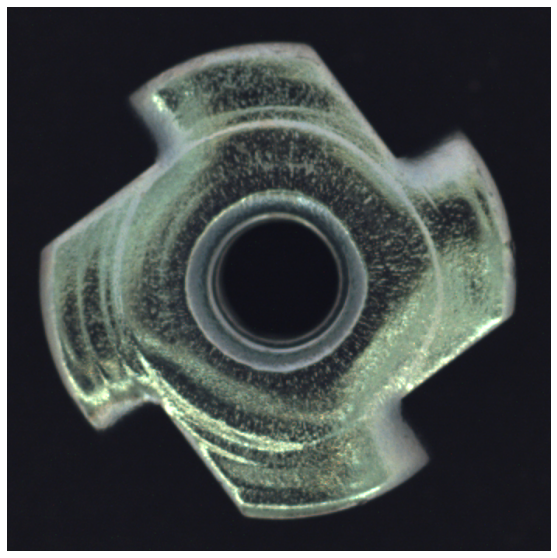

In [25]:
test_image1 = IMAGES_DIR + "/test1.png"
imageview(test_image1)

Colors distribution for test_images/test1.png


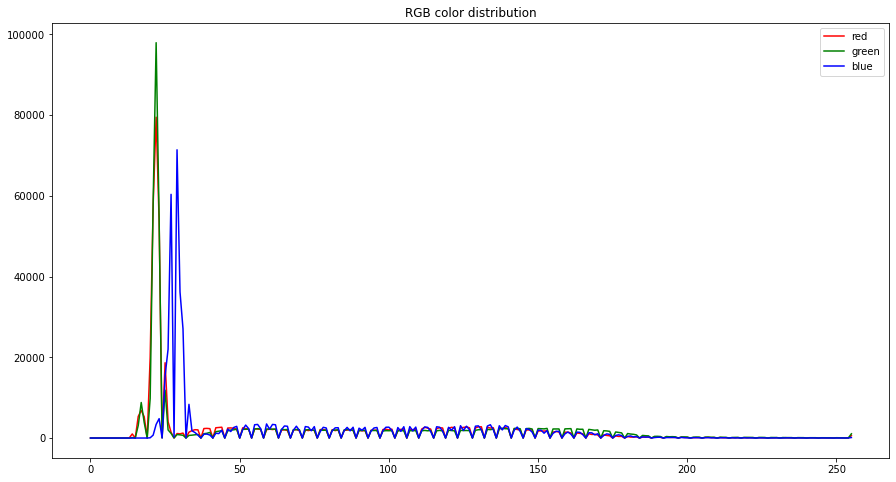

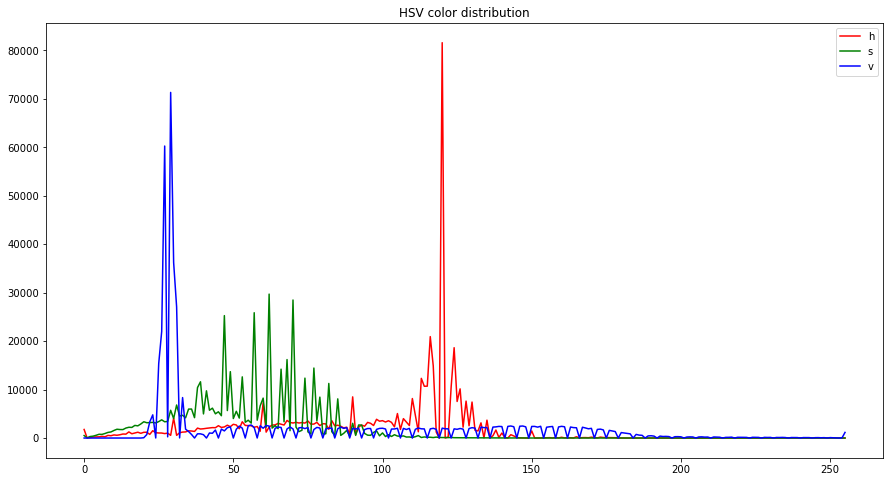

In [26]:
color_distribution(test_image1)

Get predominant colors from an image...


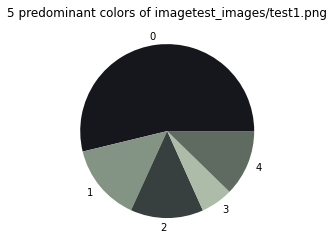

% distribution of clusters:
 [0.5379020408163265, 0.14391428571428572, 0.13548979591836735, 0.059746938775510204, 0.1229469387755102]


In [33]:
predominant_colors(test_image1)

In [34]:
resp, detections, label, imgsize, totalsurface, totalsurfacepixels\
, pcttotalsurface = callingmodel(test_image1)

Model predictions for image file: test_images/test1.png  using minimum confidence score= 0.8 

[OK]: No detected scratches


In [35]:
RenderJSON(resp.text)

Instance Segmentation custom vision model predictions:



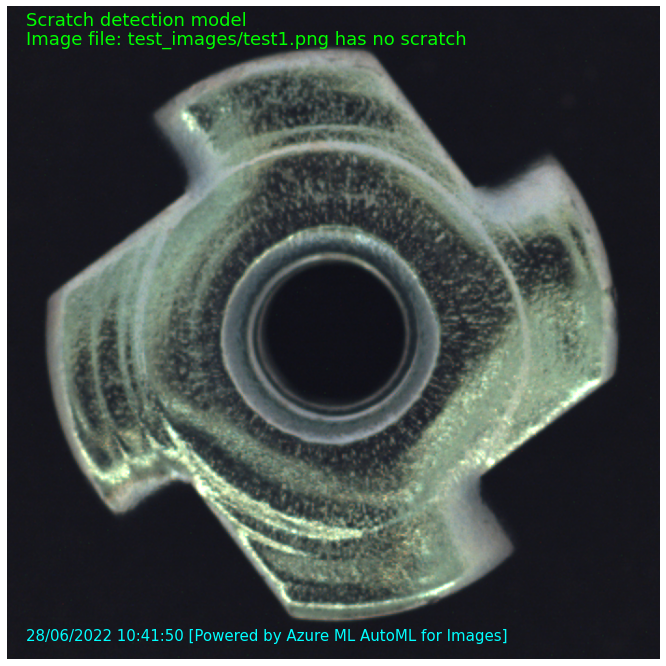

[OK]: No detected scratch


In [36]:
image_result_file1 = viewresults(test_image1)

In [37]:
image_result_file1

'images_results/test1.png_has_0_scratch.png'

In [38]:
listfiles(RESULTS_DIR)

Files in directory: images_results 

1 	 2022-06-28 08:41:53.116531 	 test1.png_has_0_scratch.png 1.0 MB


### Test 2

Image file: test_images/test2.png


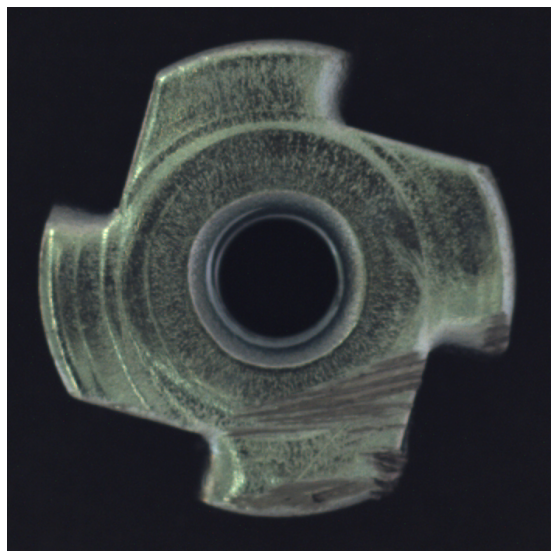

In [39]:
test_image2 = IMAGES_DIR + "/test2.png"
imageview(test_image2)

Colors distribution for test_images/test2.png


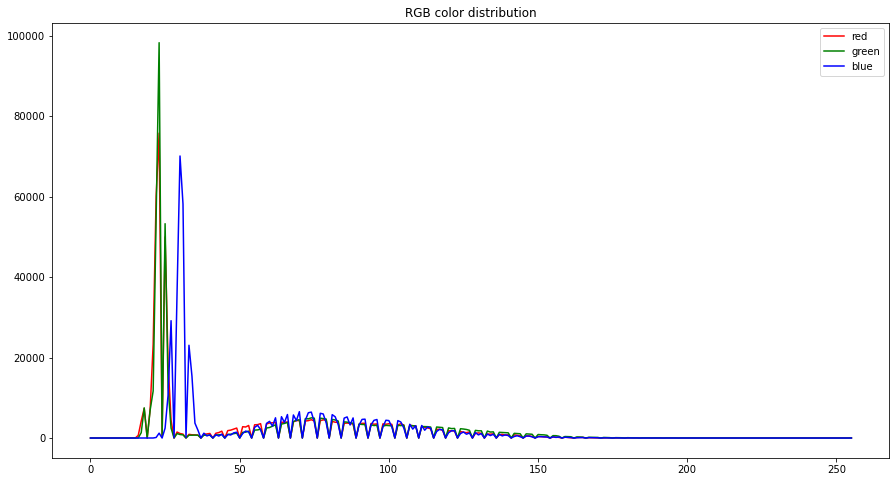

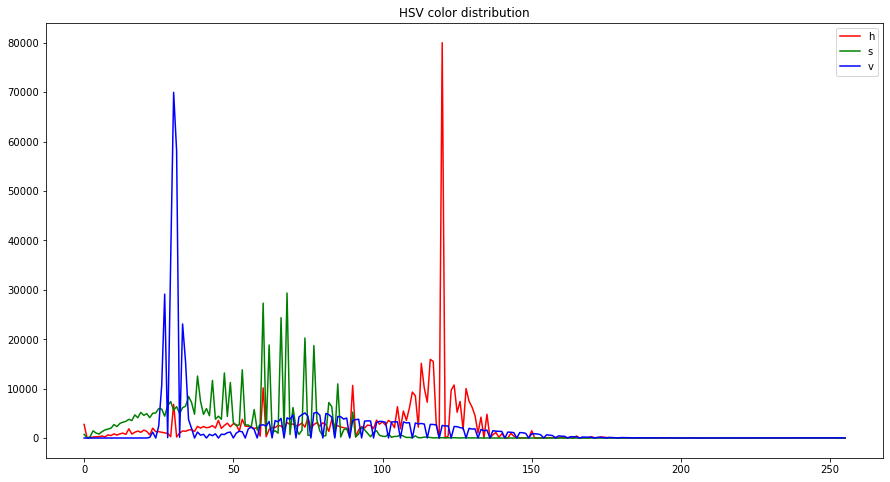

In [40]:
color_distribution(test_image2)

Get predominant colors from an image...


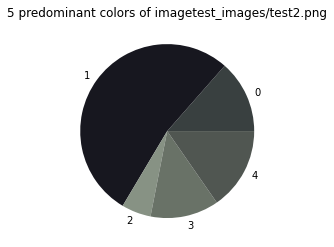

% distribution of clusters:
 [0.1351530612244898, 0.5293142857142857, 0.05481020408163265, 0.12727142857142856, 0.15345102040816327]


In [41]:
predominant_colors(test_image2)

In [42]:
resp, detections, nb_scratch, imgsize, totalsurface, totalsurfacepixels\
, pcttotalsurface = callingmodel(test_image2, 0.5)

Model predictions for image file: test_images/test2.png  using minimum confidence score= 0.5 

 1 scratch with confidence = 0.97392

Polygon: [[0.5083333333333333, 0.785, 0.42833333333333334, 0.785, 0.425, 0.7816666666666666, 0.4216666666666667, 0.7733333333333333, 0.42333333333333334, 0.7483333333333333, 0.44333333333333336, 0.7383333333333333, 0.4666666666666667, 0.7333333333333333, 0.5216666666666666, 0.715, 0.5883333333333334, 0.6866666666666666, 0.6266666666666667, 0.6766666666666666, 0.635, 0.67, 0.6516666666666666, 0.665, 0.6666666666666666, 0.655, 0.6783333333333333, 0.6533333333333333, 0.6933333333333334, 0.6466666666666666, 0.7416666666666667, 0.64, 0.7566666666666667, 0.64, 0.765, 0.6433333333333333, 0.7666666666666667, 0.655, 0.7616666666666667, 0.6833333333333333, 0.7416666666666667, 0.7066666666666667, 0.735, 0.7183333333333334, 0.735, 0.7283333333333334, 0.7283333333333334, 0.7416666666666667, 0.7116666666666667, 0.7566666666666667, 0.6683333333333333, 0.7683333333333333

In [43]:
RenderJSON(resp.text)

Instance Segmentation custom vision model predictions:

 1 	scratch detected: scratch with confidence = 0.97392 	in region: 295.21028 436.87113 259.23976 121.02764
 2 	scratch detected: scratch with confidence = 0.86331 	in region: 464.84945 569.4493 46.8261 41.88461
 3 	scratch detected: scratch with confidence = 0.65118 	in region: 301.28693 598.48376 169.50569 50.05288
 4 	scratch detected: scratch with confidence = 0.53358 	in region: 609.5483 395.651 34.64453 42.88354


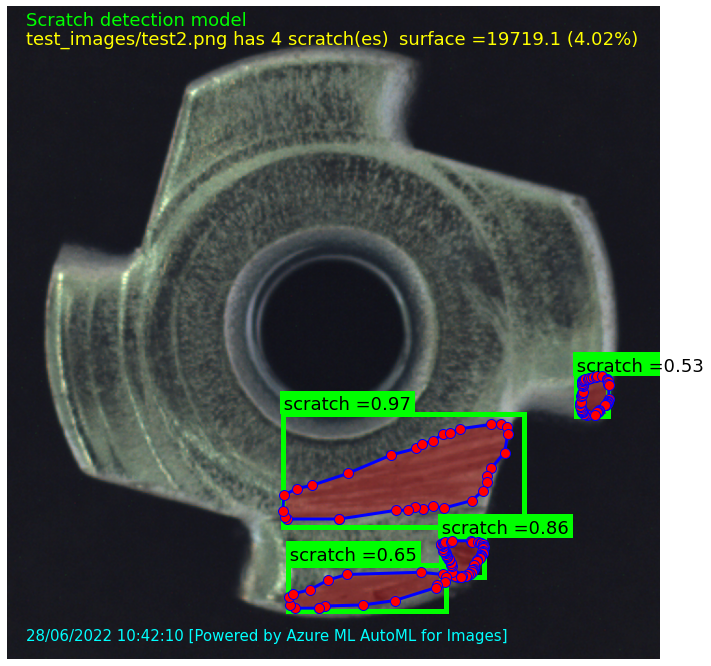


[ALERT]: 4 scratch(es) has been detected!


In [44]:
image_result_file2 = viewresults(test_image2, 0.5)

In [45]:
image_result_file2

'images_results/test2.png_has_4_scratch.png'

In [46]:
listfiles(RESULTS_DIR)

Files in directory: images_results 

1 	 2022-06-28 08:41:53.116531 	 test1.png_has_0_scratch.png 1.0 MB
2 	 2022-06-28 08:42:12.973309 	 test2.png_has_4_scratch.png 1.2 MB


#### Extraction of the scratched ROI

In [47]:
listfiles(ROI_RESULTS_DIR)

Files in directory: roi_images 

1 	 2022-06-28 08:42:10.229860 	 test2.png_1_ROI.png 43.2 kB
2 	 2022-06-28 08:42:10.344795 	 test2.png_2_ROI.png 2.9 kB
3 	 2022-06-28 08:42:10.502705 	 test2.png_3_ROI.png 11.8 kB
4 	 2022-06-28 08:42:10.632631 	 test2.png_4_ROI.png 2.2 kB


Image file: roi_images/test2.png_1_ROI.png


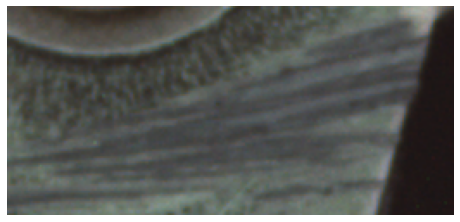

In [48]:
images = [file for file in os.listdir(ROI_RESULTS_DIR) if\
          file.startswith(os.path.basename(test_image2))]

imageview(ROI_RESULTS_DIR + '/' + images[0], 8, 5)

Image file: roi_images/test2.png_2_ROI.png


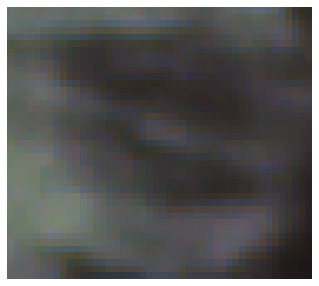

In [49]:
imageview(ROI_RESULTS_DIR + '/' + images[1], 8, 5)

Image file: roi_images/test2.png_3_ROI.png


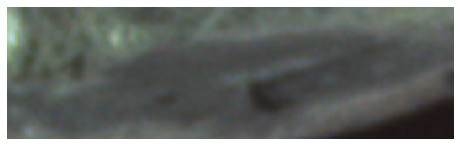

In [50]:
imageview(ROI_RESULTS_DIR + '/' + images[2], 8, 5)

Image file: roi_images/test2.png_4_ROI.png


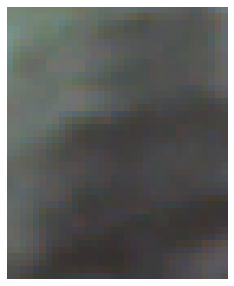

In [51]:
imageview(ROI_RESULTS_DIR + '/' + images[3], 8, 5)

### Test 3

Image file: test_images/test3.png


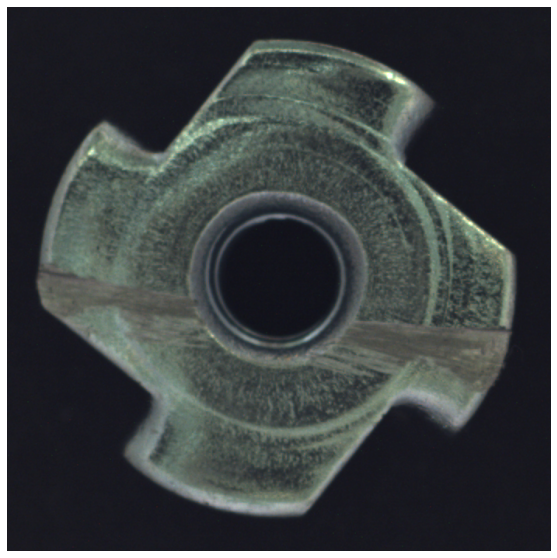

In [52]:
test_image3 = IMAGES_DIR + "/test3.png"
imageview(test_image3)

Colors distribution for test_images/test3.png


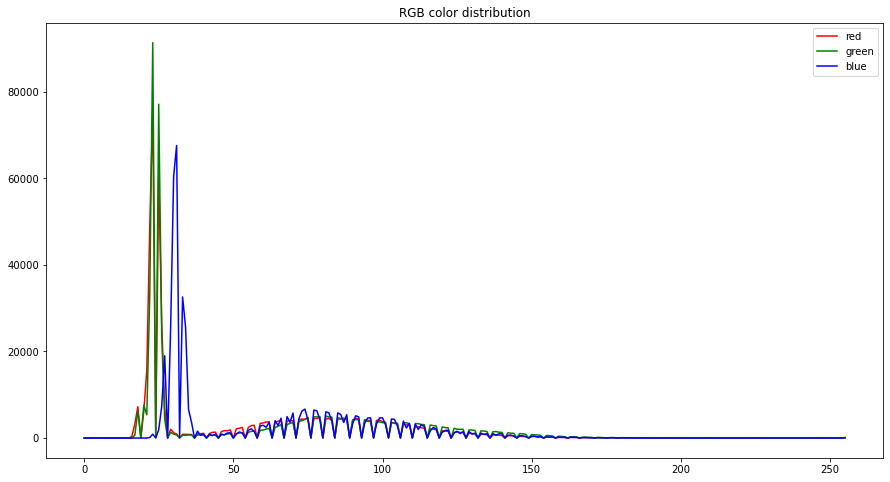

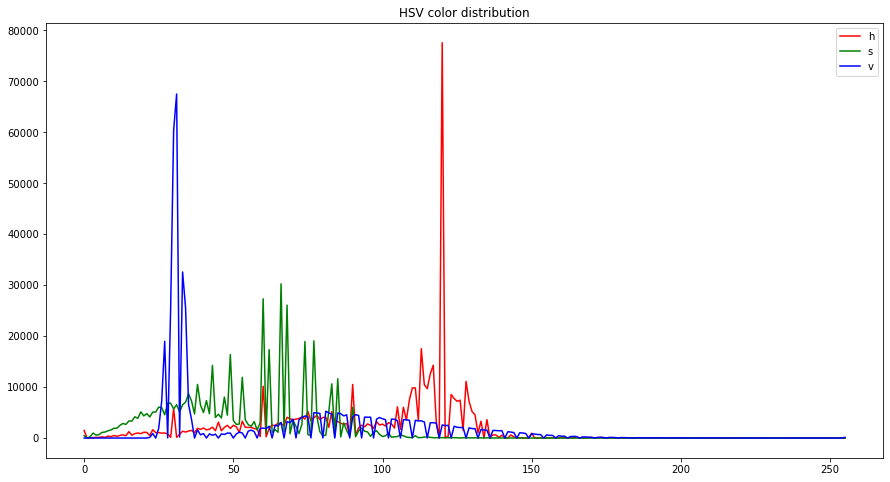

In [53]:
color_distribution(test_image3)

Get predominant colors from an image...


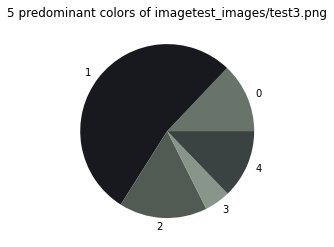

% distribution of clusters:
 [0.1292, 0.5310387755102041, 0.16390816326530613, 0.04803673469387755, 0.12781632653061226]


In [54]:
predominant_colors(test_image3)

In [55]:
resp, detections, nb_scratch, imgsize, totalsurface, totalsurfacepixels\
, pcttotalsurface = callingmodel(test_image3)

Model predictions for image file: test_images/test3.png  using minimum confidence score= 0.8 

 1 scratch with confidence = 0.96986

Polygon: [[0.8633333333333333, 0.6933333333333334, 0.8483333333333334, 0.6916666666666667, 0.8366666666666667, 0.6783333333333333, 0.8233333333333334, 0.6733333333333333, 0.8033333333333333, 0.6583333333333333, 0.7833333333333333, 0.65, 0.7416666666666667, 0.65, 0.7283333333333334, 0.655, 0.72, 0.655, 0.71, 0.6633333333333333, 0.6983333333333334, 0.6683333333333333, 0.6566666666666666, 0.6733333333333333, 0.6133333333333333, 0.67, 0.5666666666666667, 0.6583333333333333, 0.5633333333333334, 0.65, 0.5633333333333334, 0.6416666666666667, 0.5666666666666667, 0.635, 0.595, 0.6233333333333333, 0.6083333333333333, 0.61, 0.62, 0.605, 0.6283333333333333, 0.5933333333333334, 0.6366666666666667, 0.5866666666666667, 0.6533333333333333, 0.5816666666666667, 0.6833333333333333, 0.5816666666666667, 0.695, 0.585, 0.7633333333333333, 0.59, 0.77, 0.5933333333333334, 0.81333

In [56]:
RenderJSON(resp.text)

Instance Segmentation custom vision model predictions:

 1 	scratch detected: scratch with confidence = 0.96986 	in region: 393.18326 399.93474 250.93267 86.45695
 2 	scratch detected: scratch with confidence = 0.96297 	in region: 43.53979 337.43765 207.12026 84.71265


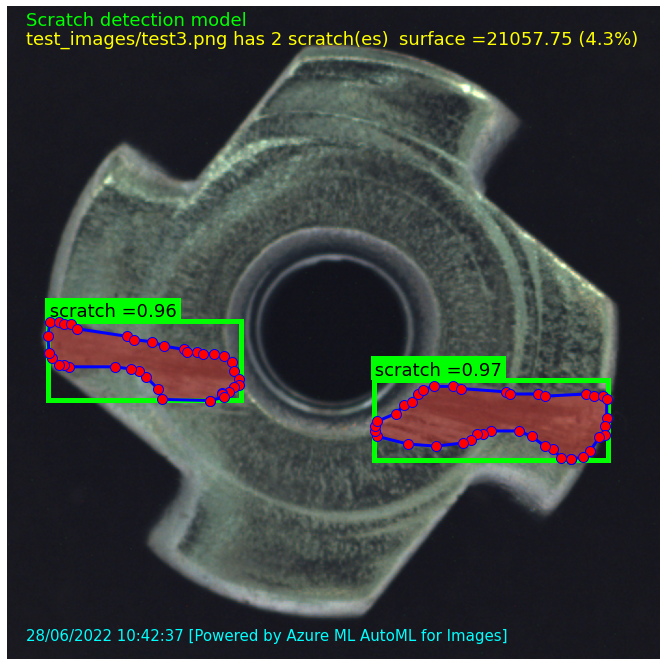


[ALERT]: 2 scratch(es) has been detected!


In [57]:
image_result_file3 = viewresults(test_image3)

In [58]:
image_result_file3

'images_results/test3.png_has_2_scratch.png'

In [59]:
listfiles(RESULTS_DIR)

Files in directory: images_results 

1 	 2022-06-28 08:41:53.116531 	 test1.png_has_0_scratch.png 1.0 MB
2 	 2022-06-28 08:42:12.973309 	 test2.png_has_4_scratch.png 1.2 MB
3 	 2022-06-28 08:42:40.111960 	 test3.png_has_2_scratch.png 1.1 MB


#### Extraction of the scratched ROI

In [60]:
listfiles(ROI_RESULTS_DIR)

Files in directory: roi_images 

1 	 2022-06-28 08:42:10.229860 	 test2.png_1_ROI.png 43.2 kB
2 	 2022-06-28 08:42:10.344795 	 test2.png_2_ROI.png 2.9 kB
3 	 2022-06-28 08:42:10.502705 	 test2.png_3_ROI.png 11.8 kB
4 	 2022-06-28 08:42:10.632631 	 test2.png_4_ROI.png 2.2 kB
5 	 2022-06-28 08:42:37.707320 	 test3.png_1_ROI.png 30.9 kB
6 	 2022-06-28 08:42:37.841244 	 test3.png_2_ROI.png 23.6 kB


Image file: roi_images/test3.png_1_ROI.png


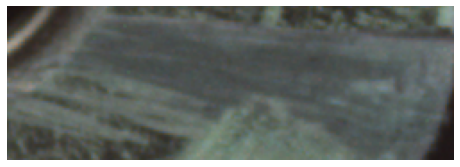

In [61]:
images = [file for file in os.listdir(ROI_RESULTS_DIR) \
          if file.startswith(os.path.basename(test_image3))]

imageview(ROI_RESULTS_DIR + '/' + images[0], 8, 5)

Image file: roi_images/test3.png_2_ROI.png


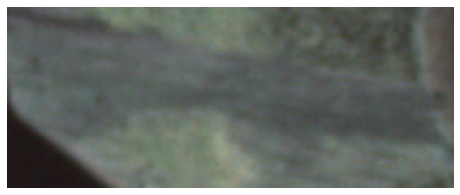

In [62]:
imageview(ROI_RESULTS_DIR + '/' + images[1], 8, 5)

### Test 4

Image file: test_images/test4.png


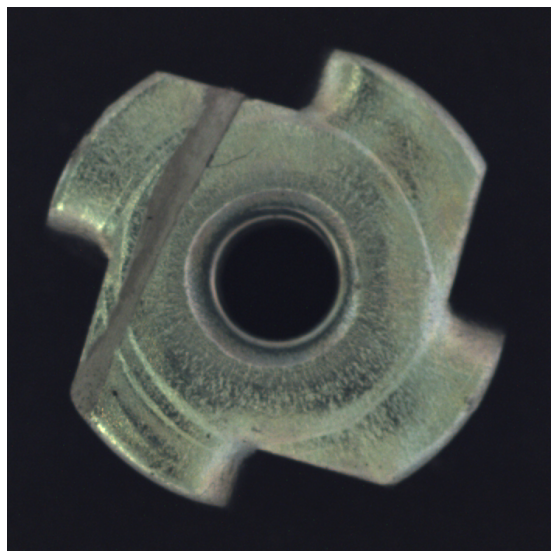

In [63]:
test_image4 = IMAGES_DIR + "/test4.png"
imageview(test_image4)

Colors distribution for test_images/test4.png


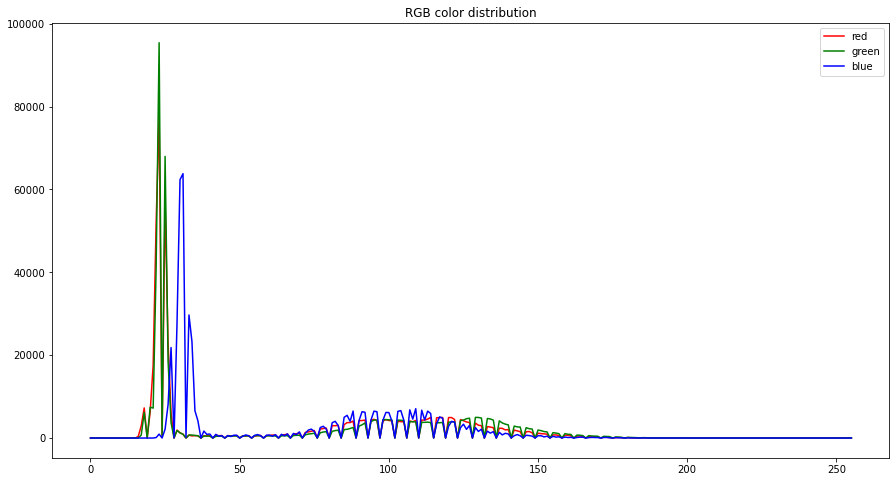

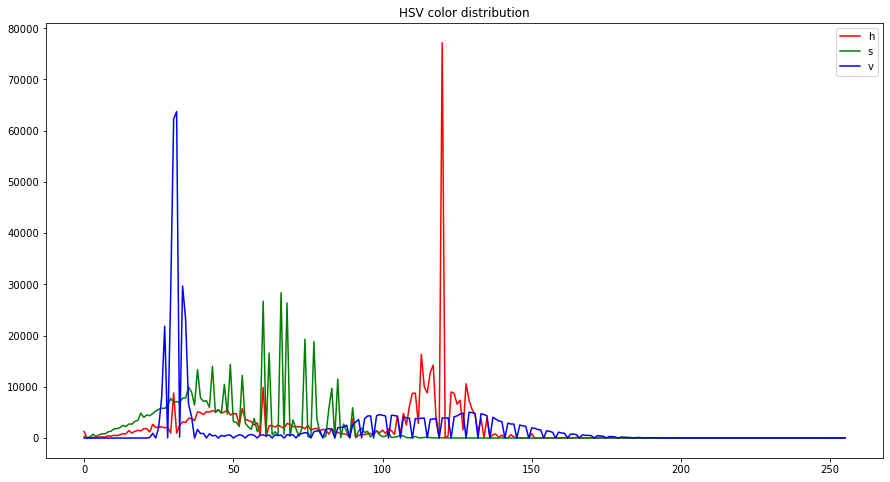

In [64]:
color_distribution(test_image4)

Get predominant colors from an image...


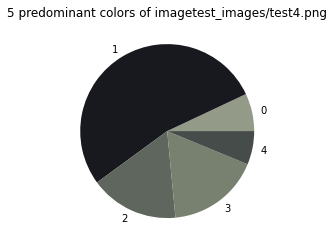

% distribution of clusters:
 [0.07001428571428571, 0.5305673469387755, 0.1646061224489796, 0.17250408163265307, 0.062308163265306124]


In [65]:
predominant_colors(test_image4)

In [66]:
resp, detections, nb_scratch, imgsize, totalsurface, totalsurfacepixels\
, pcttotalsurface = callingmodel(test_image4)

Model predictions for image file: test_images/test4.png  using minimum confidence score= 0.8 

 1 scratch with confidence = 0.96293

Polygon: [[0.14333333333333334, 0.75, 0.135, 0.7466666666666667, 0.13166666666666665, 0.7383333333333333, 0.13, 0.6733333333333333, 0.13333333333333333, 0.6533333333333333, 0.14, 0.6366666666666667, 0.14833333333333334, 0.6266666666666667, 0.15333333333333332, 0.6133333333333333, 0.16333333333333333, 0.6, 0.17666666666666667, 0.57, 0.185, 0.5583333333333333, 0.19333333333333333, 0.53, 0.20666666666666667, 0.5083333333333333, 0.21, 0.485, 0.22333333333333333, 0.465, 0.225, 0.44333333333333336, 0.235, 0.42333333333333334, 0.23833333333333334, 0.4, 0.25166666666666665, 0.38, 0.25666666666666665, 0.35833333333333334, 0.2733333333333333, 0.33666666666666667, 0.2816666666666667, 0.31333333333333335, 0.3016666666666667, 0.29333333333333333, 0.31166666666666665, 0.27, 0.3283333333333333, 0.25333333333333335, 0.33666666666666667, 0.22666666666666666, 0.34833333333

In [67]:
RenderJSON(resp.text)

Instance Segmentation custom vision model predictions:

 1 	scratch detected: scratch with confidence = 0.96293 	in region: 90.79416 110.27937 203.09631 416.41234


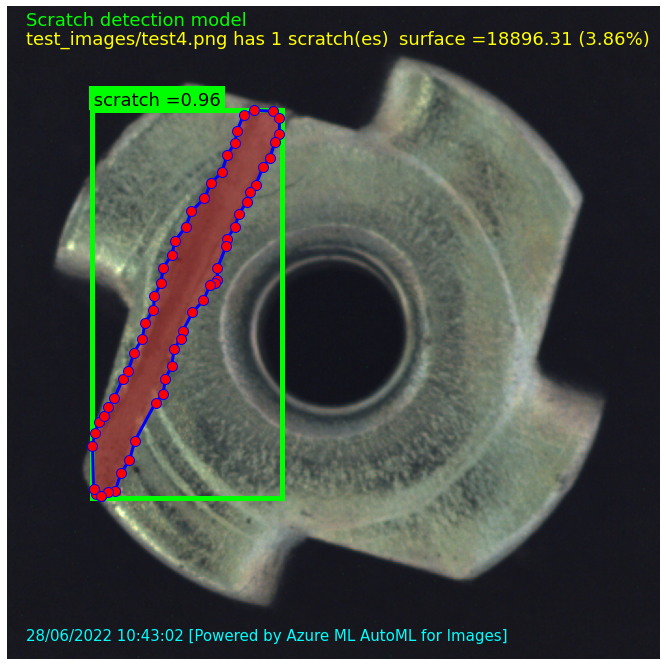


[ALERT]: 1 scratch(es) has been detected!


In [68]:
image_result_file4 = viewresults(test_image4)

In [69]:
image_result_file4

'images_results/test4.png_has_1_scratch.png'

In [70]:
listfiles(RESULTS_DIR)

Files in directory: images_results 

1 	 2022-06-28 08:41:53.116531 	 test1.png_has_0_scratch.png 1.0 MB
2 	 2022-06-28 08:42:12.973309 	 test2.png_has_4_scratch.png 1.2 MB
3 	 2022-06-28 08:42:40.111960 	 test3.png_has_2_scratch.png 1.1 MB
4 	 2022-06-28 08:43:05.124801 	 test4.png_has_1_scratch.png 1.1 MB


In [71]:
listfiles(ROI_RESULTS_DIR)

Files in directory: roi_images 

1 	 2022-06-28 08:42:10.229860 	 test2.png_1_ROI.png 43.2 kB
2 	 2022-06-28 08:42:10.344795 	 test2.png_2_ROI.png 2.9 kB
3 	 2022-06-28 08:42:10.502705 	 test2.png_3_ROI.png 11.8 kB
4 	 2022-06-28 08:42:10.632631 	 test2.png_4_ROI.png 2.2 kB
5 	 2022-06-28 08:42:37.707320 	 test3.png_1_ROI.png 30.9 kB
6 	 2022-06-28 08:42:37.841244 	 test3.png_2_ROI.png 23.6 kB
7 	 2022-06-28 08:43:02.741150 	 test4.png_1_ROI.png 129.3 kB


Image file: roi_images/test4.png_1_ROI.png


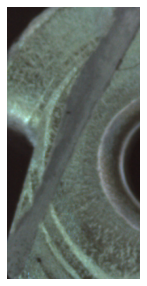

In [72]:
images = [file for file in os.listdir(ROI_RESULTS_DIR) \
          if file.startswith(os.path.basename(test_image4))]

imageview(ROI_RESULTS_DIR + '/' + images[0], 8, 5)

## 6. Misc

In [73]:
listfiles(RESULTS_DIR)

Files in directory: images_results 

1 	 2022-06-28 08:41:53.116531 	 test1.png_has_0_scratch.png 1.0 MB
2 	 2022-06-28 08:42:12.973309 	 test2.png_has_4_scratch.png 1.2 MB
3 	 2022-06-28 08:42:40.111960 	 test3.png_has_2_scratch.png 1.1 MB
4 	 2022-06-28 08:43:05.124801 	 test4.png_has_1_scratch.png 1.1 MB


In [74]:
print("Generating an animated GIF file from the results images files ...")

mygif_file = 'animatedgif.gif'
list_images = []

images = [file for file in os.listdir(RESULTS_DIR)\
          if file.endswith(('png'))]

for image in images:
    list_images.append(imageio.imread(RESULTS_DIR + '/' + image))
    imageio.mimsave(mygif_file, list_images, duration=3, fps=30)

print("Done. Animated Gif file has been created:", mygif_file)

Generating an animated GIF file from the results images files ...
Done. Animated Gif file has been created: animatedgif.gif


In [75]:
!ls *.gif -lh

-rwxrwxrwx 1 root root 21M Jun 28 08:44 animatedgif.gif
